### first checking the implicit method is correct or not in the numerical solution of the Allen-Cahn eqaution

C:\Users\Manju\AppData\Local\Temp\ipykernel_12704\902003417.py:55: RuntimeWarning: invalid value encountered in sqrt
  uk = jnp.tanh((2 - sqrt(xx*2 + yy*2)) / (sqrt(2) * epsillon))


TypeError: unsupported operand type(s) for -: 'ArrayImpl' and 'list'

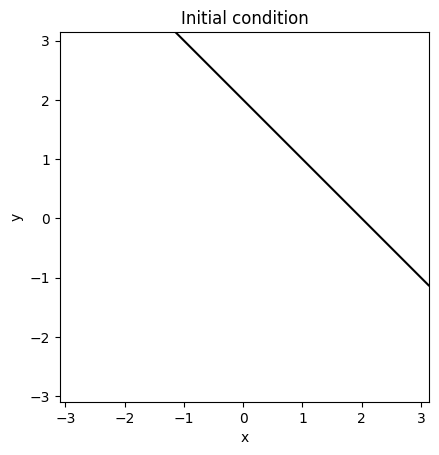

In [ ]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# Defining the number of grid points in x and y
Nx = 128  # number of grid points in x (positive even integer)
Ny = 128  # number of grid points in y (positive even integer)

# Define the parameters of the Allen-Cahn equation in 2D
Lx = 2.0 * jnp.pi  # length of the domain in x
Ly = 2.0 * jnp.pi  # length of the domain in y
hx = Lx / Nx  # spatial step size in x
hy = Ly / Ny  # spatial step size in y
dt = 0.0001  # time step size
T = 4  # final time
Nt = int(jnp.round(T / dt))  # number of time steps
ns = Nt / 10  # number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5 * Lx + hx, 0.5 * Lx, Nx)
    return x

x = x_gridpoint(Nx, Lx, hx)

def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5 * Ly + hy, 0.5 * Ly, Ny)
    return y

y = y_gridpoint(Ny, Ly, hy)

# Create meshgrid in x and y direction
xx, yy = jnp.meshgrid(x, y)

# Define parameters for the Allen-Cahn equation
epsillon = 0.05  # small parameter (interface thickness)
cahn = epsillon**2  # Cahn number

# Initial condition of Allen-Cahn equation
uk = jnp.tanh((2 - sqrt(xx*2 + yy*2)) / (sqrt(2) * epsillon))

# Define the wavenumber in x and y direction in Fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx // 2), 2 * jnp.pi / Lx * jnp.arange(-Nx // 2, 0)]).tolist()
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny // 2), 2 * jnp.pi / Ly * jnp.arange(-Ny // 2, 0)]).tolist()

# Square of wavenumber in x and y direction
p2 = p**2
q2 = q**2

# Create meshgrid for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)

# Plotting the initial condition of the Allen-Cahn equation
figure1 = plt.figure()
plt.contour(x, y, jnp.real(uk.T), [0], colors='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')

# Define the nonlinear function and its derivative
def f(u):
    return (u**2 - 1) * u

def f_prime(u):
    return 3 * u**2 - 1

# Newton's method for implicit scheme
def newton_method(u_hat, dt, eps, pp2, qq2):
    def residual(u_hat_new):
        u_new = ifft2(u_hat_new)
        u_old = ifft2(u_hat)
        return fft2((u_new - u_old) / dt - jnp.gradient(u_new) + (u_new*3 - u_new) / eps*2)

    def jacobian(u_hat_new):
        u_new = ifft2(u_hat_new)
        return fft2(1 / dt - jnp.gradient(u_new) + (3 * u_new*2 - 1) / eps*2)

    u_hat_new = u_hat
    for _ in range(10):  # Newton iteration
        res = residual(u_hat_new)
        jac = jacobian(u_hat_new)
        u_hat_new = u_hat_new - res / jac

    return u_hat_new

# Time stepping
for iter in range(1, Nt):
    u_hat = fft2(uk)
    u_hat = newton_method(u_hat, dt, epsillon, pp2, qq2)
    uk = ifft2(u_hat)
    uk = jnp.real(uk)

    if iter == 2000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 4000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='green')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 10000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 20000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')

plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()


# Time stepping
for iter in range(1, Nt):
    u_hat = jfft.fft2(uk)
    u_hat = newton_method(u_hat, dt, epsillon, pp2, qq2)
    uk = jfft.ifft2(u_hat)
    uk = jnp.real(uk)

    if iter == 2000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 4000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='green')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 10000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='blue')
        plt.gca().set_aspect('equal', adjustable='box')

    if iter == 20000:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')

plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()



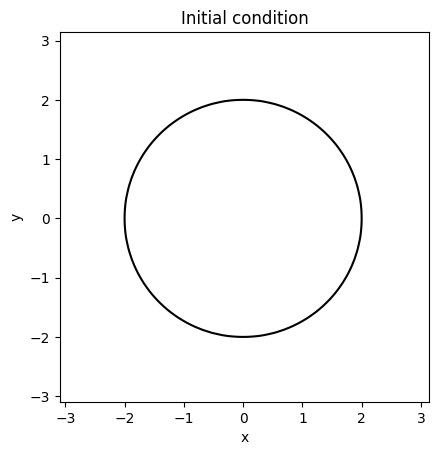

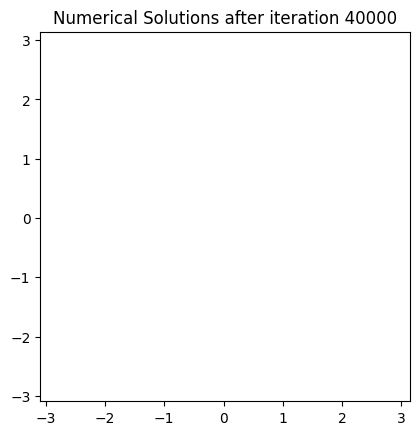

Simulation completed.


In [7]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt

# Grid parameters
Nx = 128
Ny = 128
Lx = 2.0 * jnp.pi
Ly = 2.0 * jnp.pi
hx = Lx / Nx
hy = Ly / Ny
dt = 0.0001
T = 4
Nt = int(jnp.round(T/dt))

# Grid points
x = jnp.linspace(-0.5*Lx+hx, 0.5*Lx, Nx)
y = jnp.linspace(-0.5*Ly+hy, 0.5*Ly, Ny)
xx, yy = jnp.meshgrid(x, y)

# Parameters
epsilon = 0.05
cahn = epsilon**2

# Initial condition
uk = jnp.tanh((2 - sqrt(xx**2 + yy**2)) / (sqrt(2) * epsilon))

# Wavenumbers
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2, 0)])
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2, 0)])
p2, q2 = p**2, q**2
pp2, qq2 = jnp.meshgrid(p2, q2)

# Plot initial condition
figure1 = plt.figure()
plt.contour(x, y, jnp.real(uk.T), [0], colors='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Newton iteration for implicit scheme
def newton_solve(u_old, tol=1e-6, max_iter=10):
    u_old = jnp.real(u_old)
    
    u_hat = jfft.fft2(u_old)
    for _ in range(max_iter):
        u = jnp.real(jfft.ifft2(u_hat))
        residual = jfft.fft2((u - u_old) / dt - cahn * jfft.ifft2(-(pp2 + qq2) * u_hat) + (u**3 - u))
        jacobian = jfft.fft2(1/dt - cahn * (pp2 + qq2) + 3 * u**2 - 1)
        update = residual / (jacobian + 1e-8)  # Avoid division by zero
        u_hat -= update
        if jnp.linalg.norm(update) < tol:
            break
    return jfft.ifft2(u_hat)

# Time-stepping loop
for iter in range(1, Nt):
    uk = newton_solve(uk)
    if iter in [2000, 4000, 10000, 20000]:
        plt.contour(x, y, jnp.real(uk.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box')

plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()

print("Simulation completed.")


## sucessfully running coode

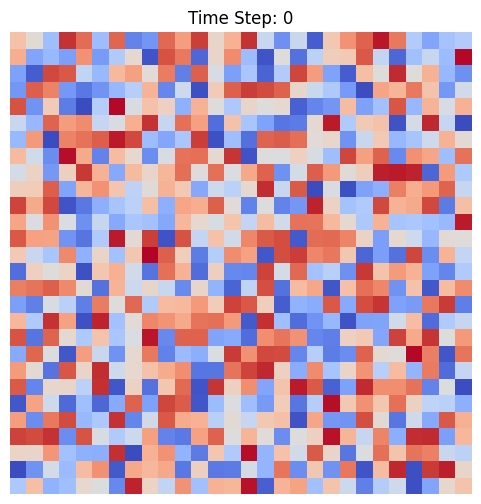

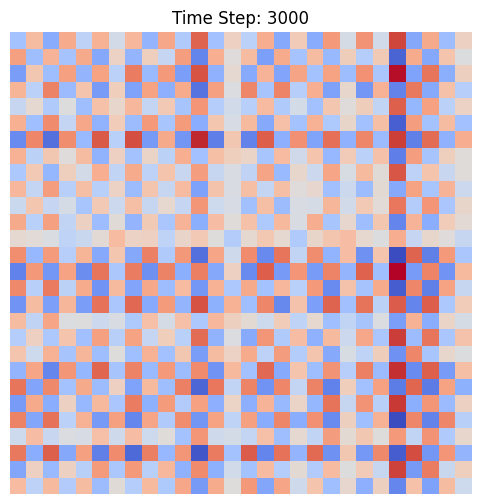

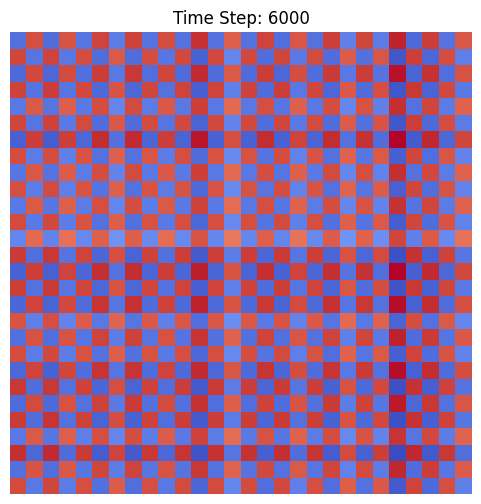

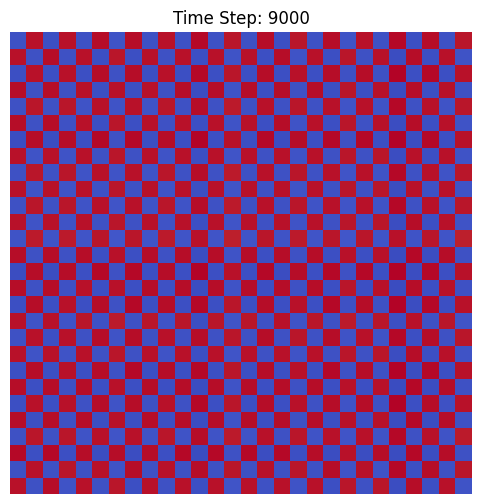

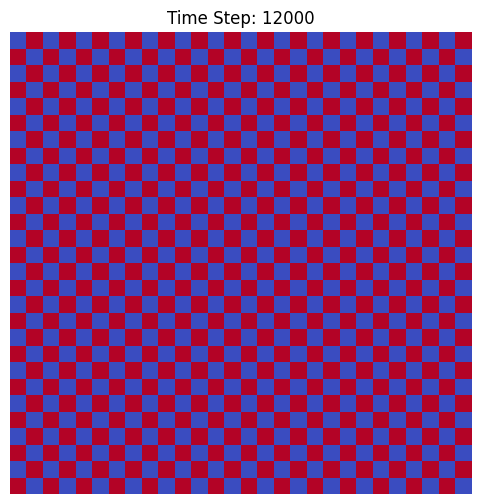

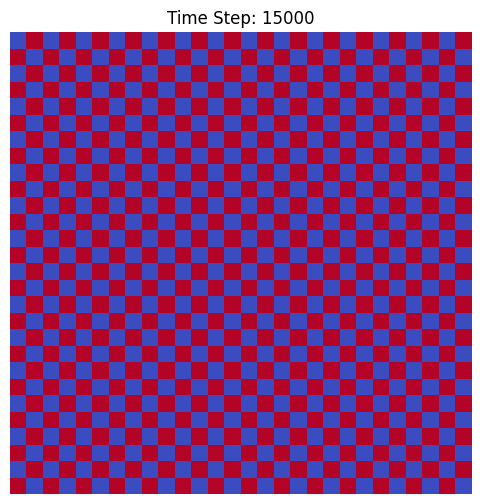

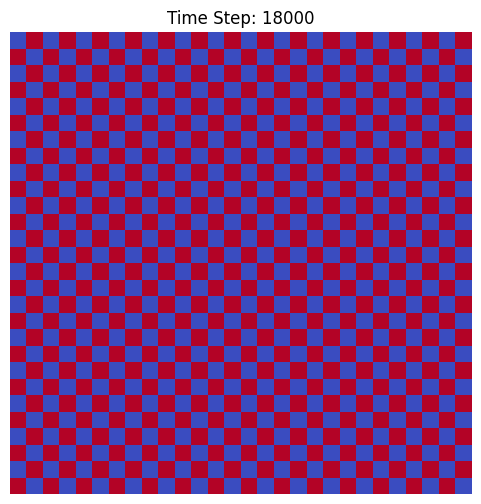

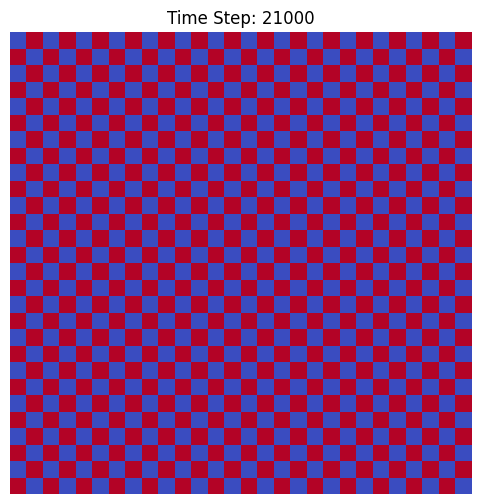

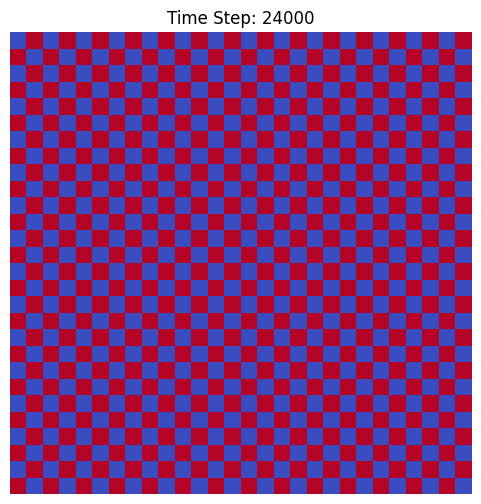

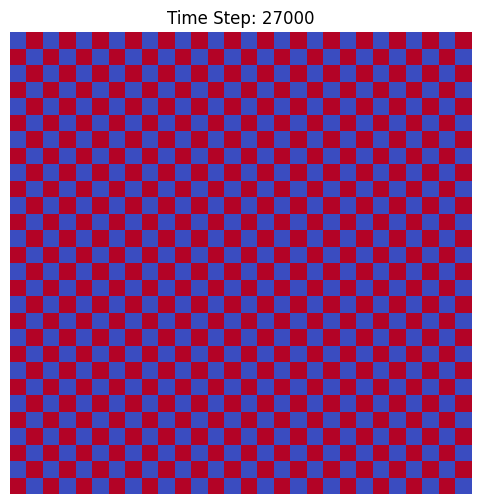

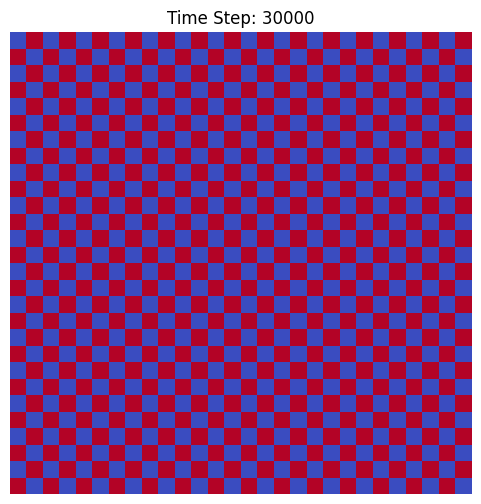

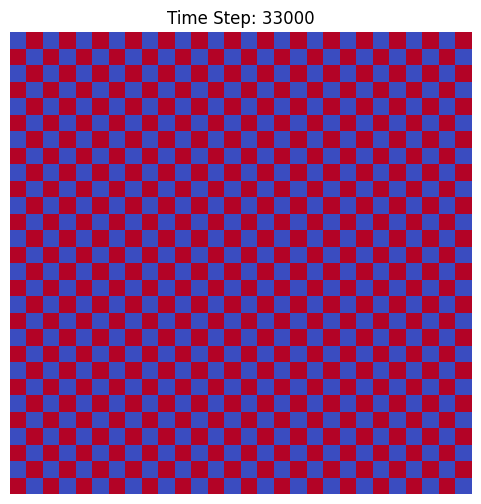

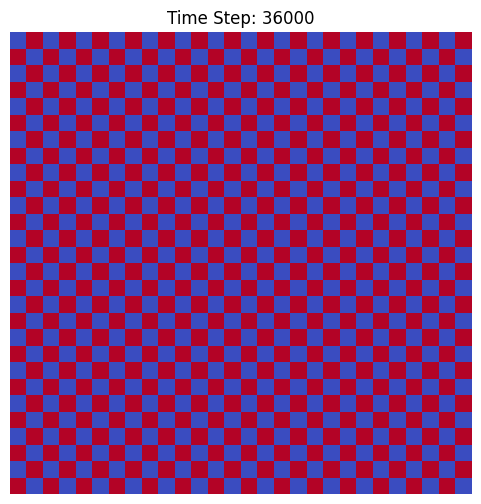

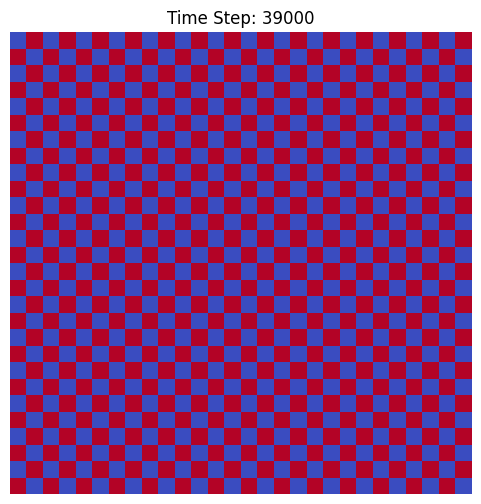

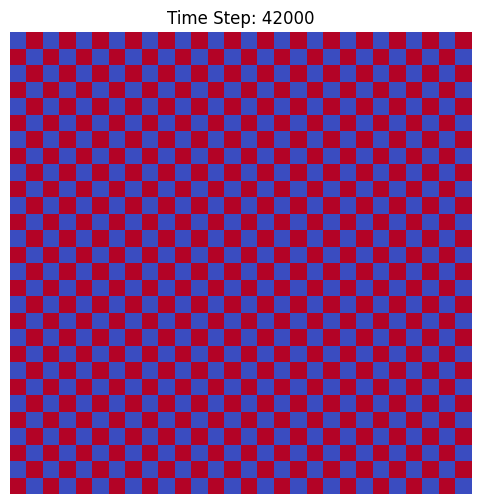

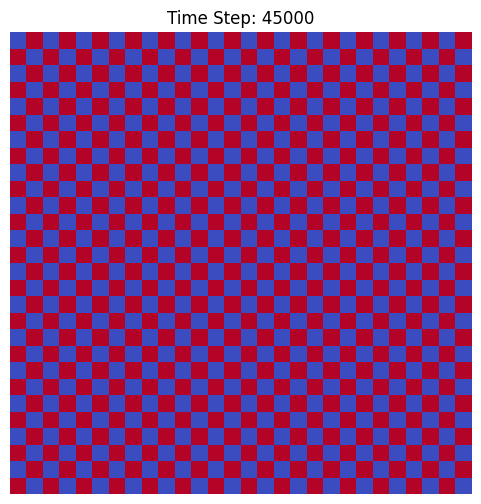

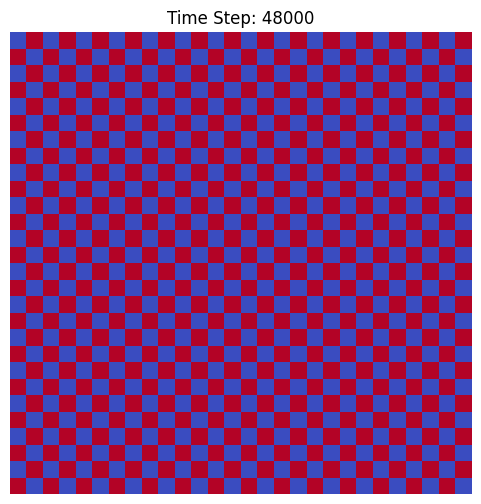

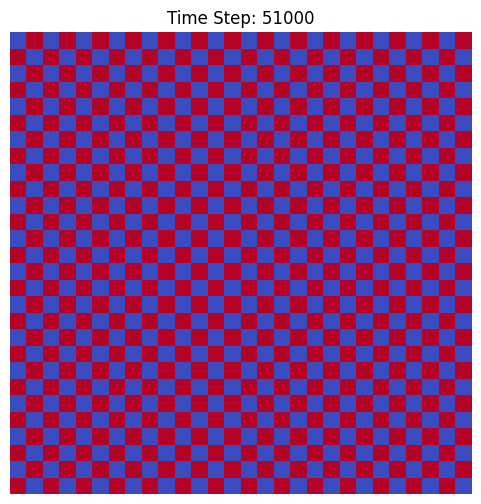

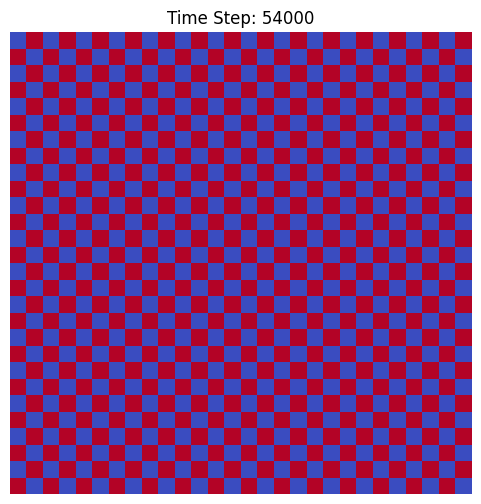

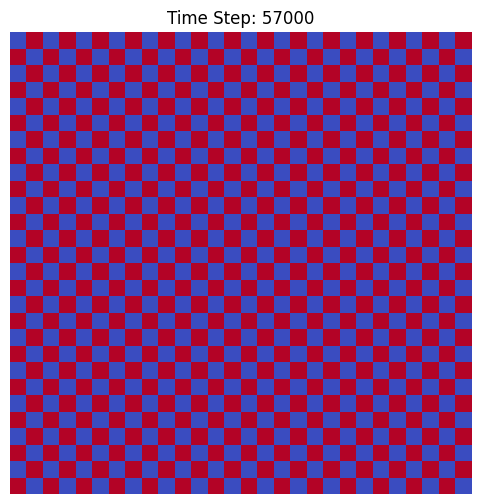

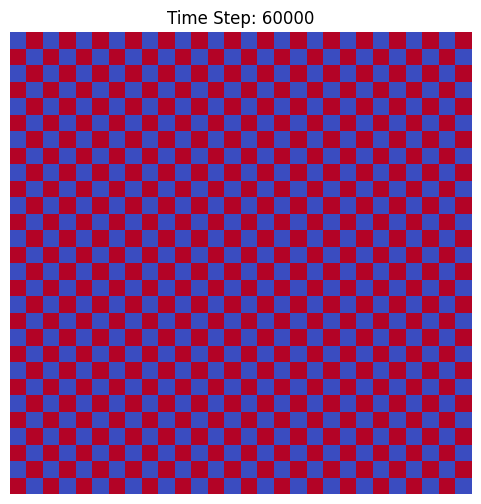

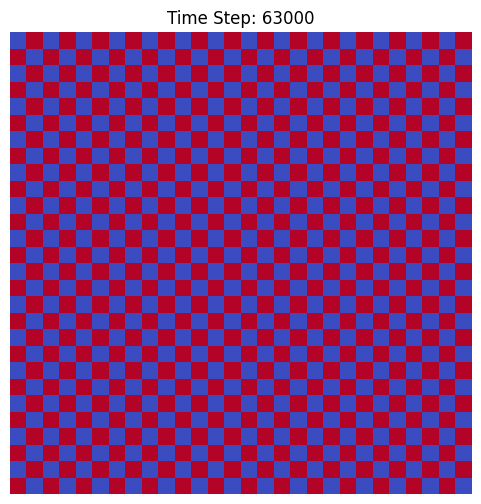

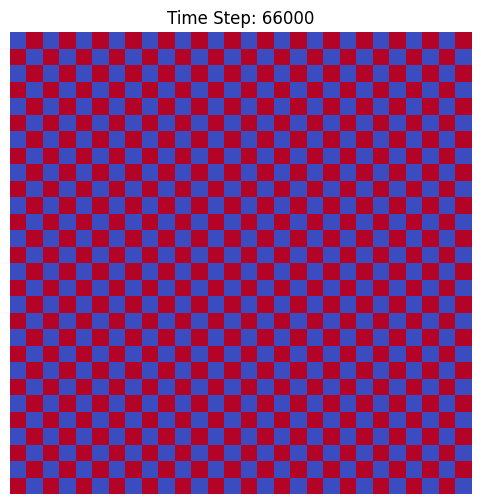

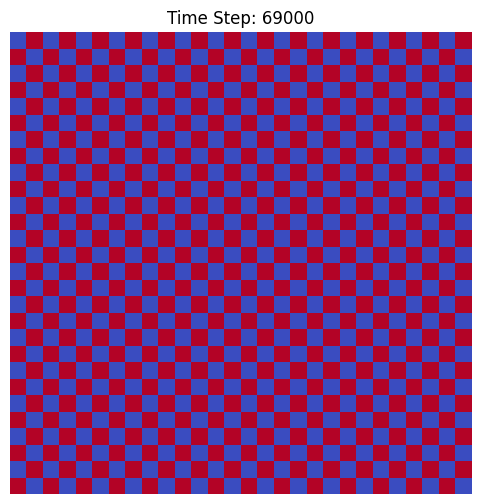

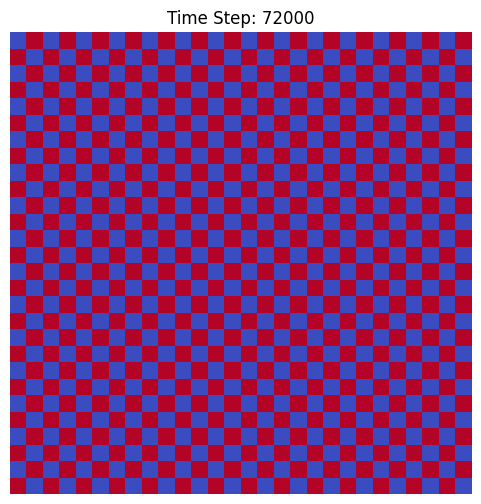

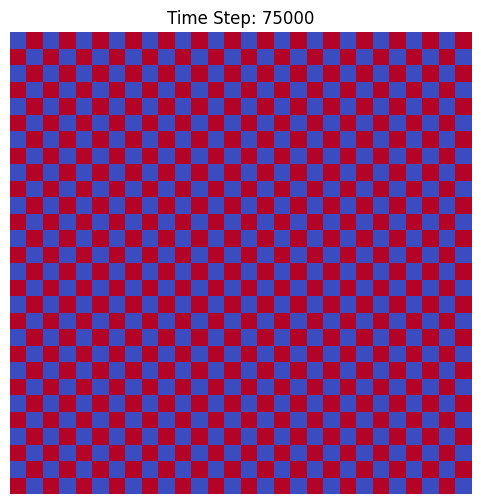

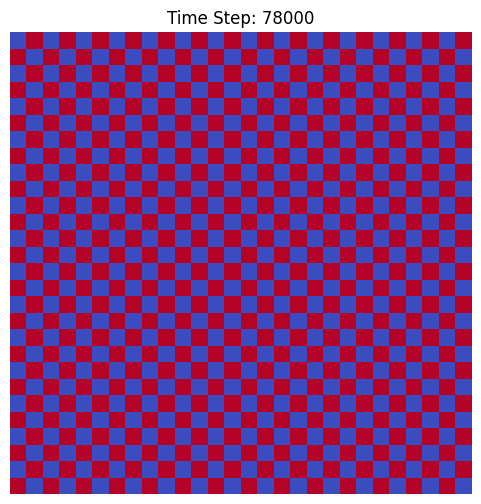

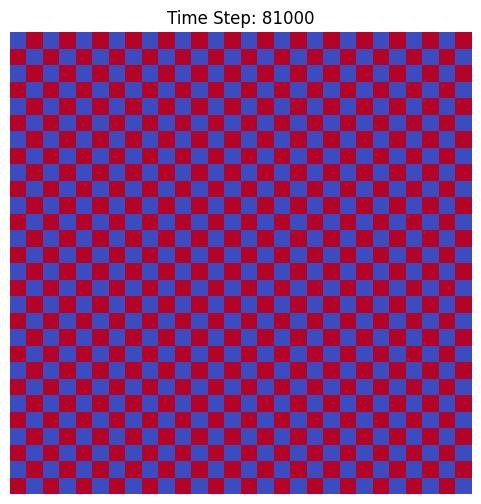

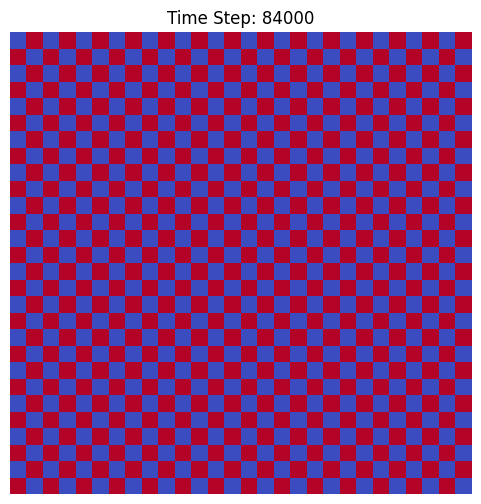

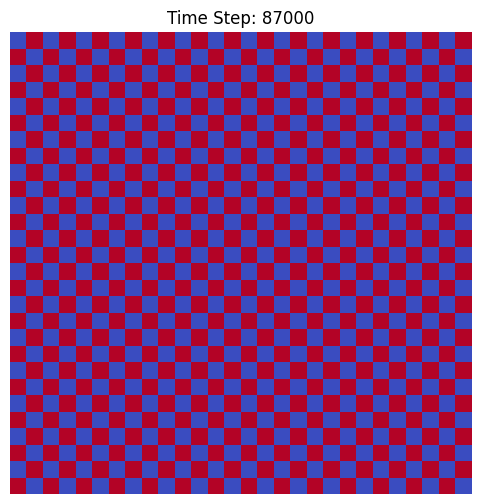

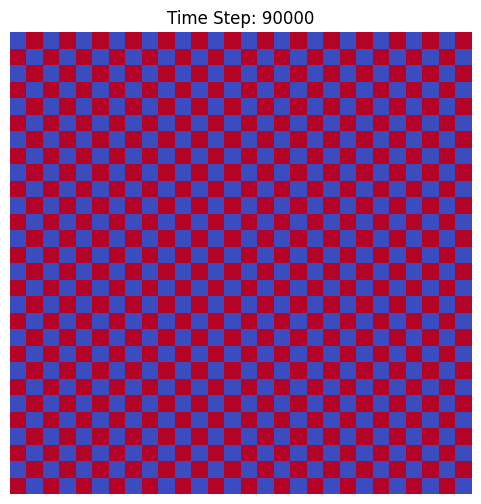

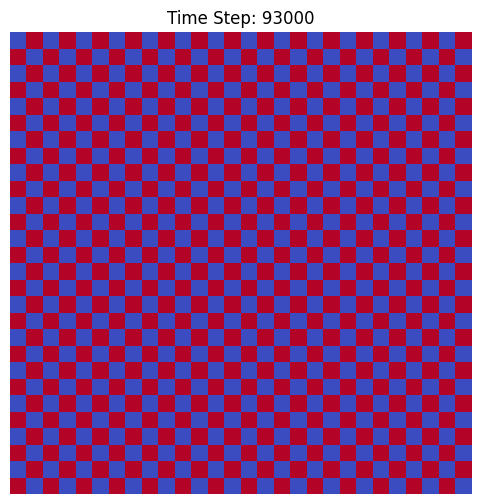

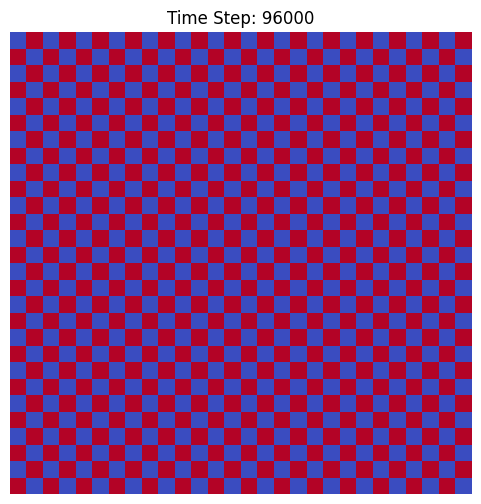

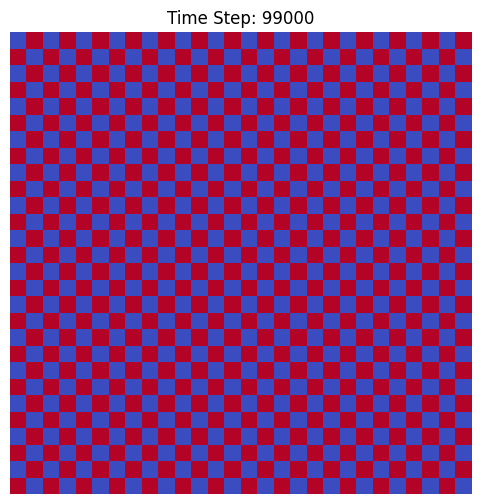

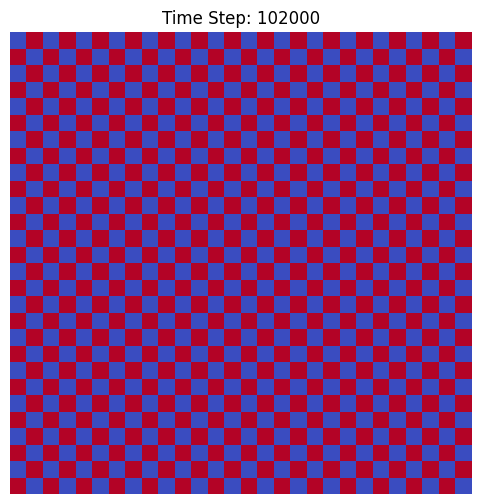

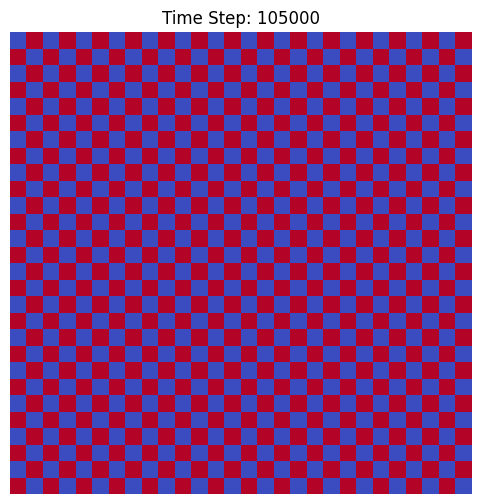

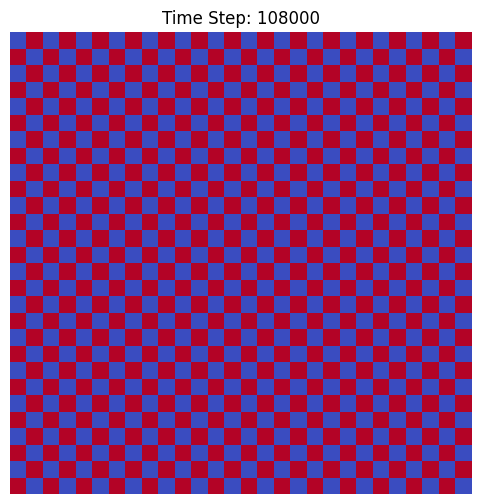

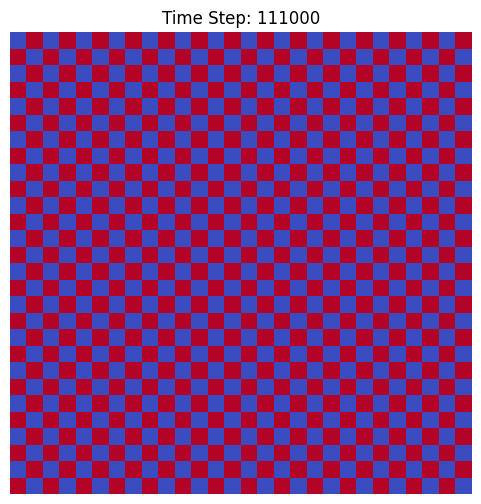

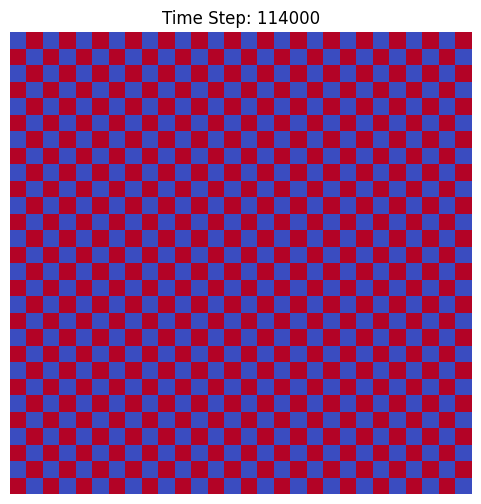

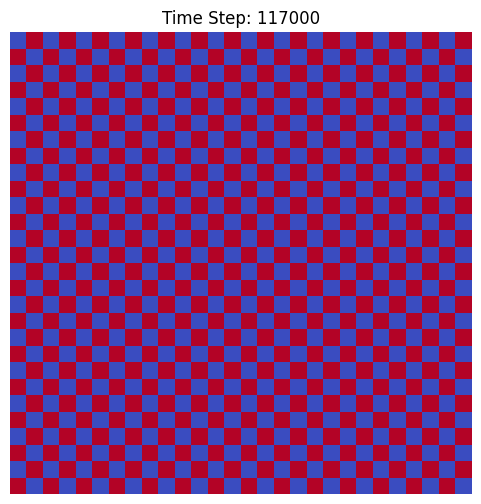

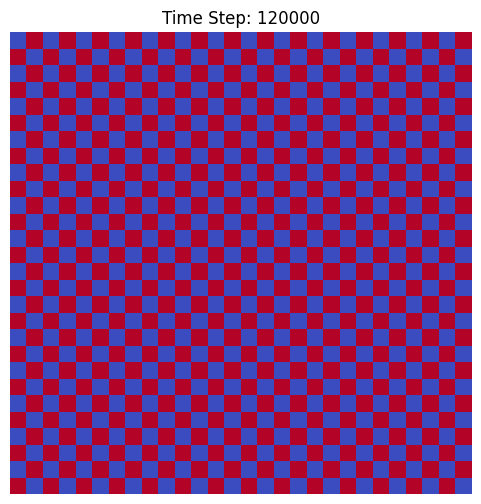

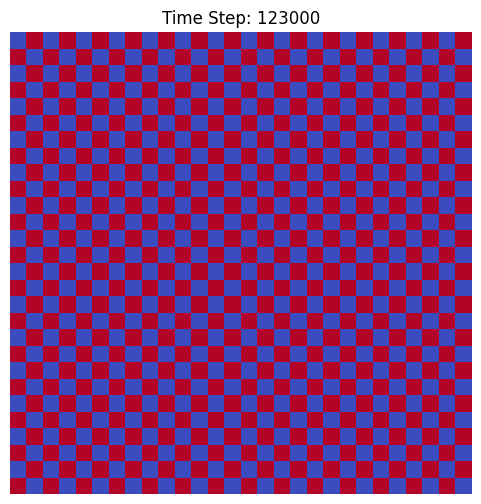

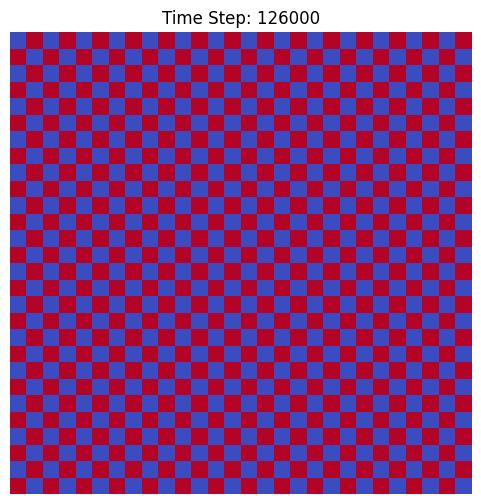

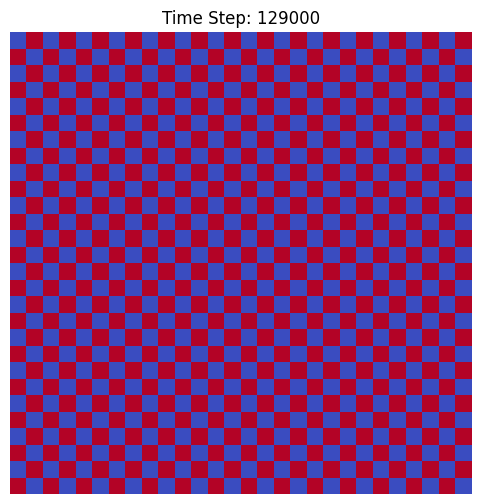

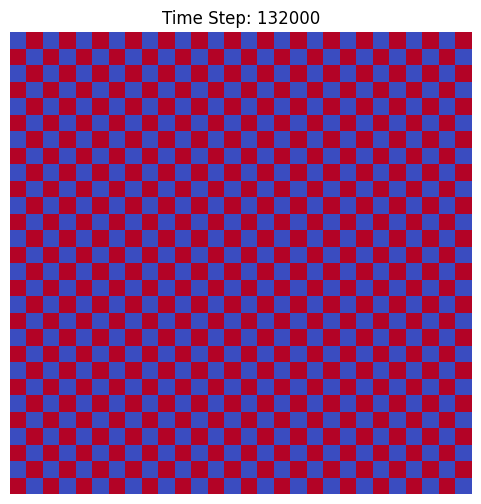

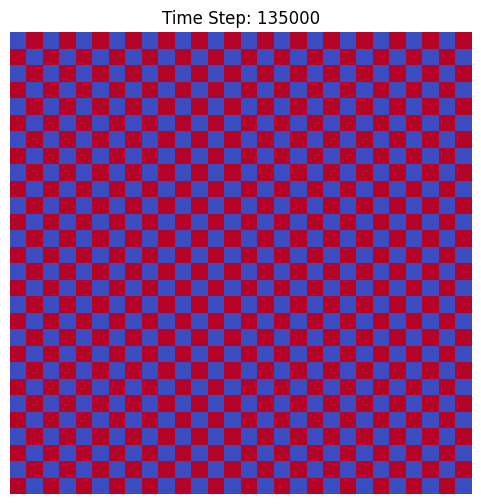

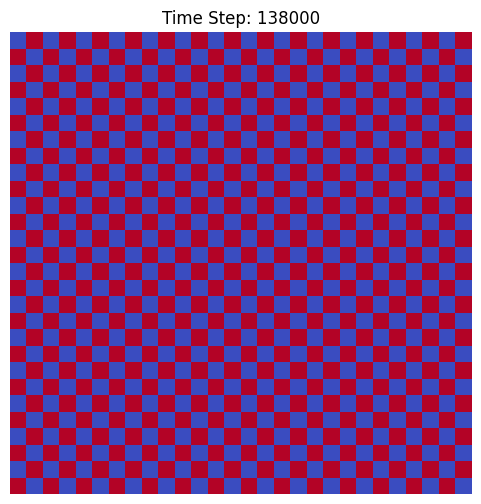

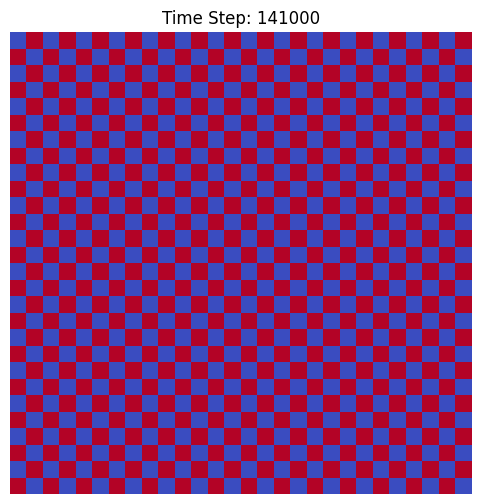

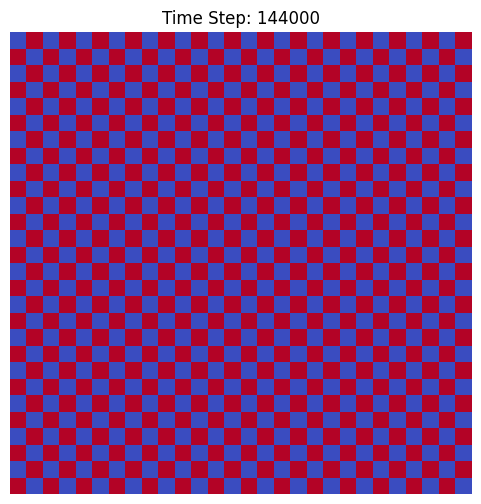

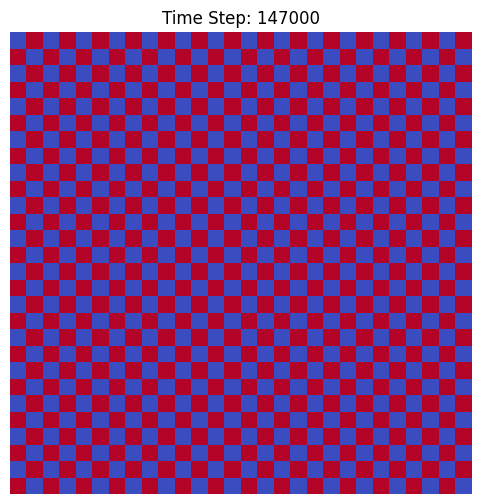

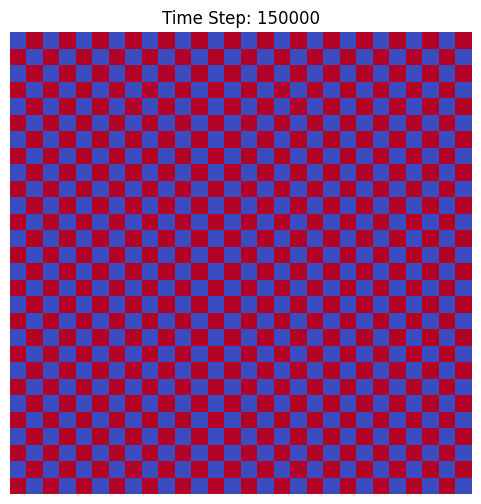

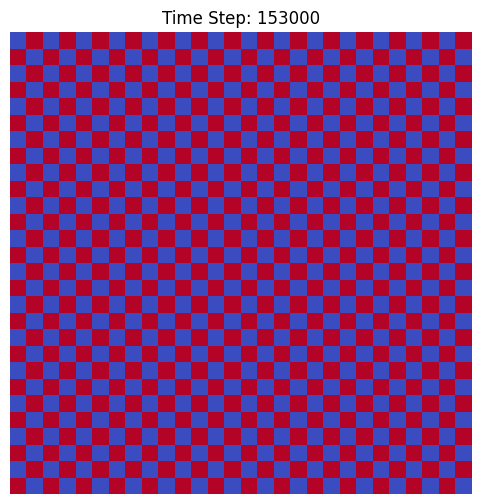

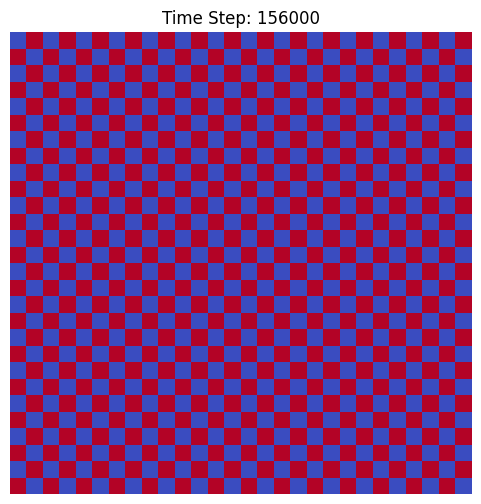

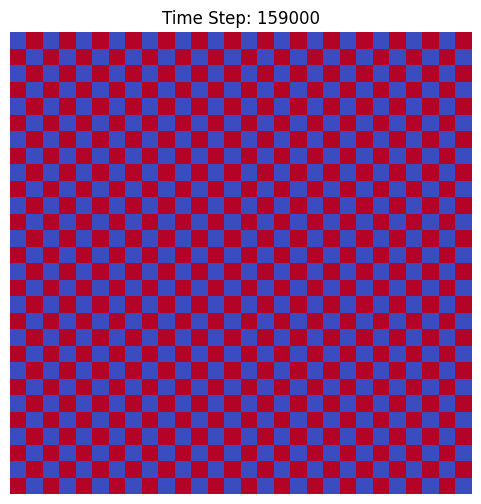

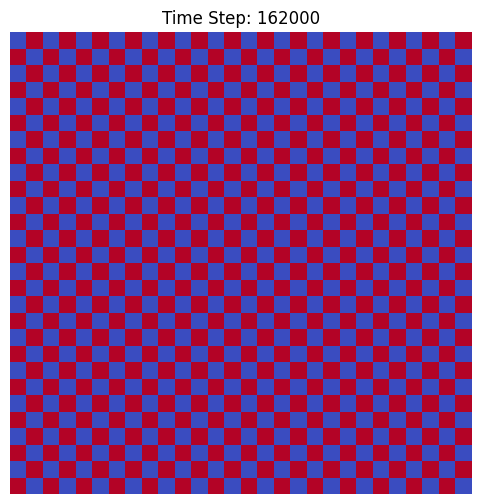

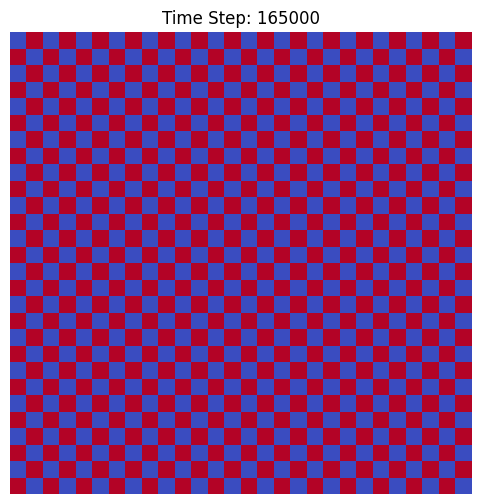

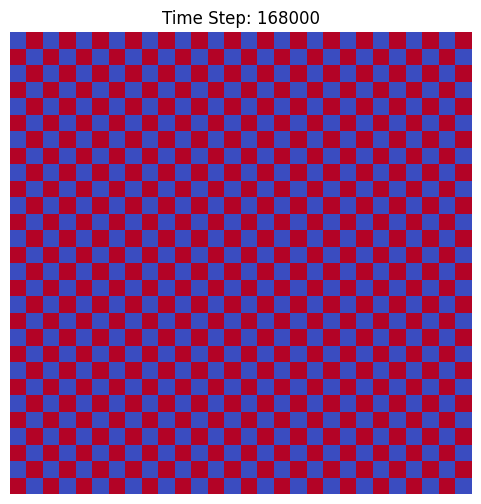

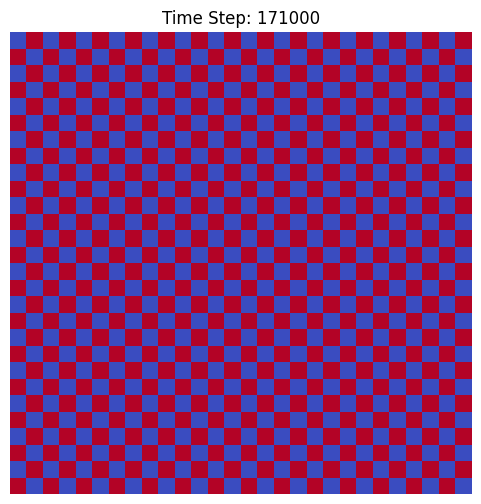

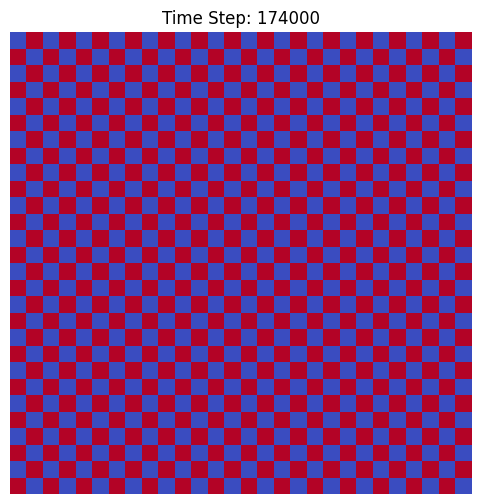

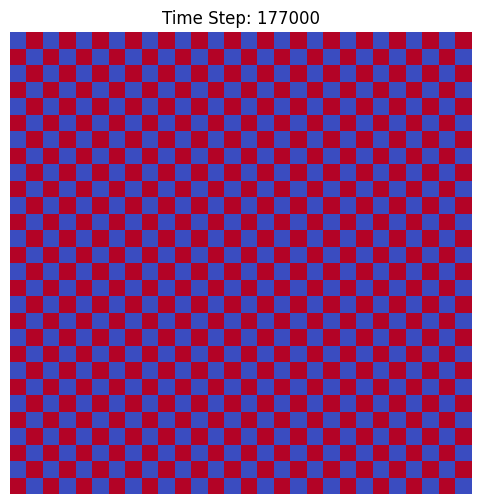

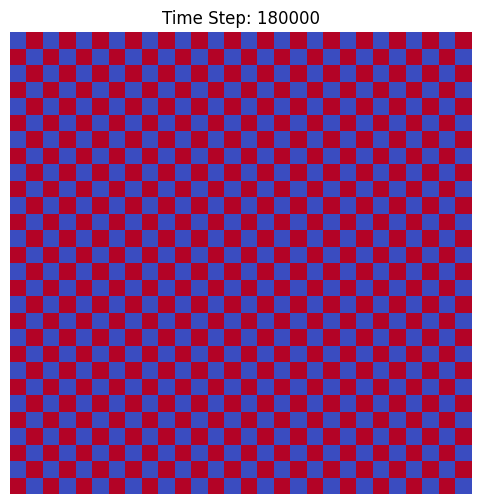

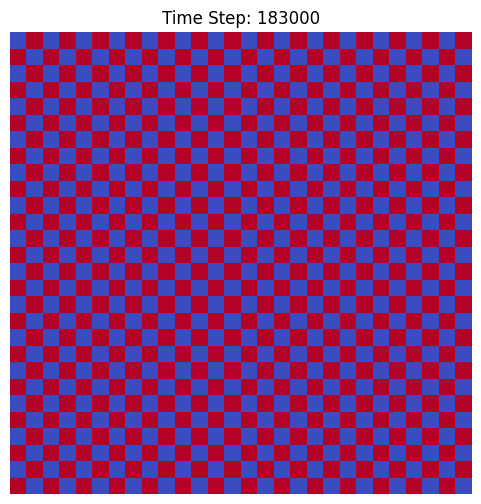

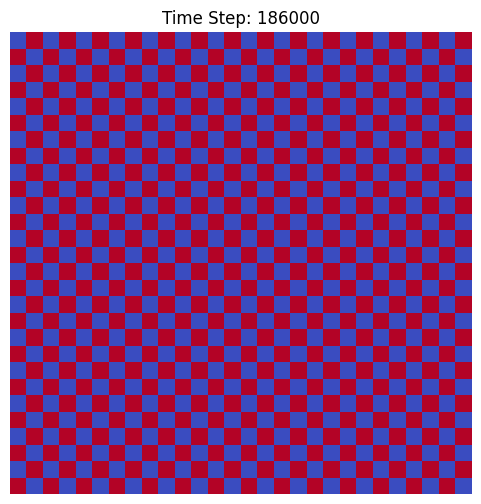

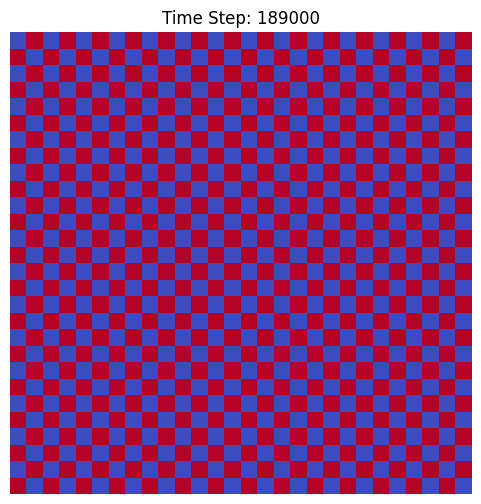

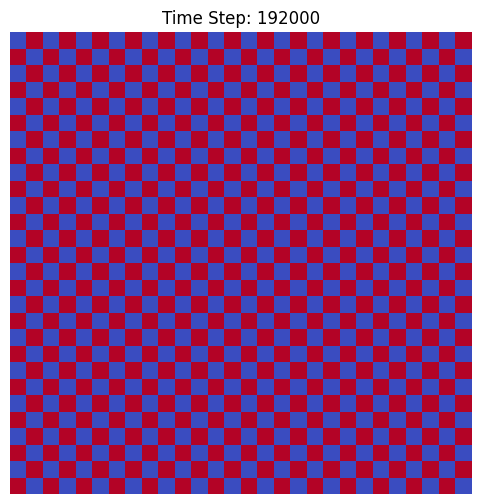

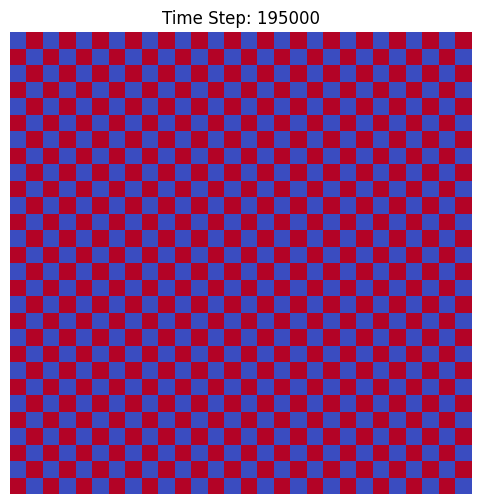

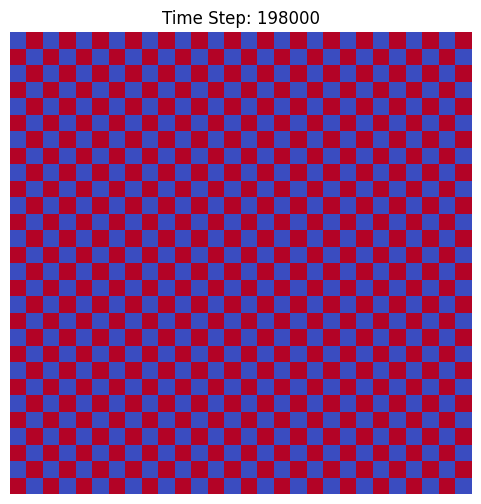

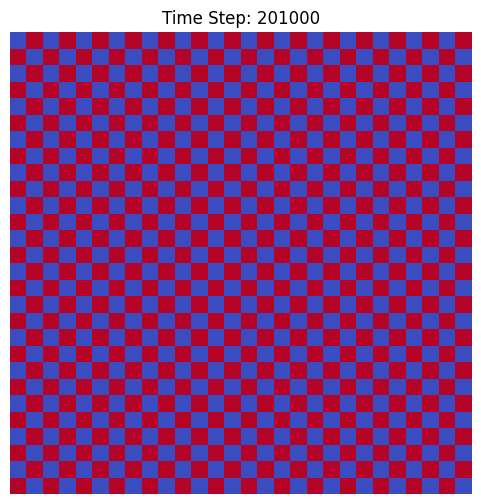

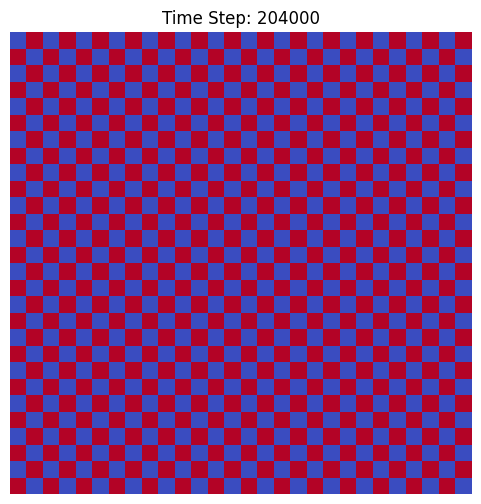

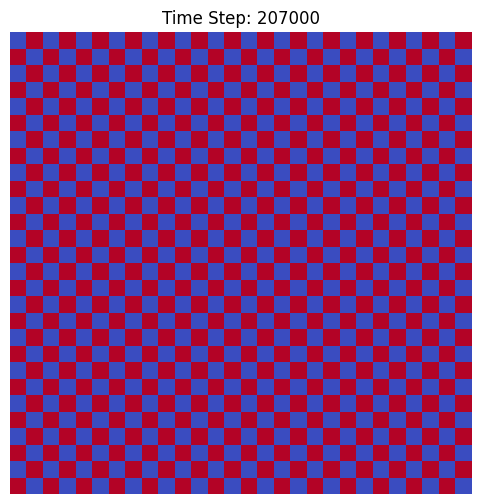

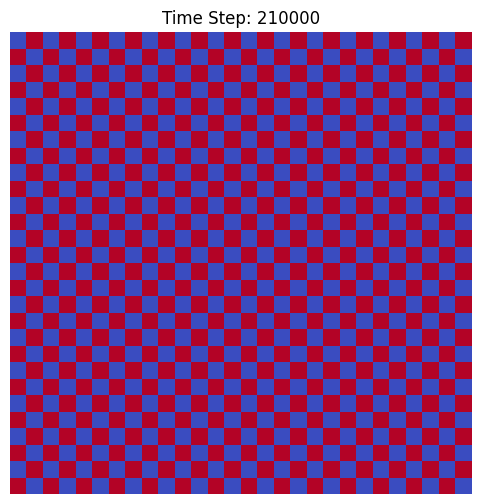

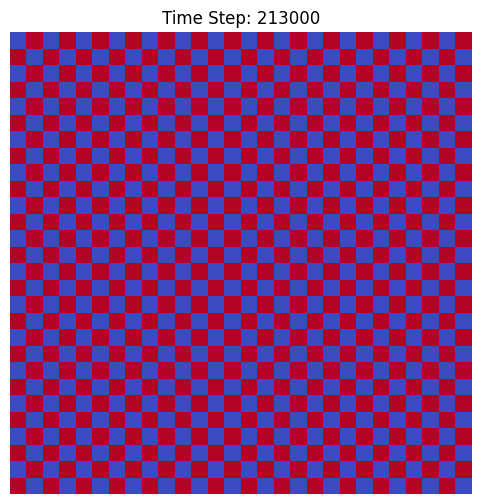

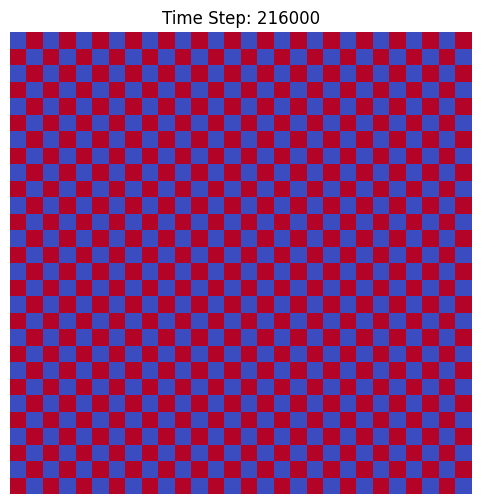

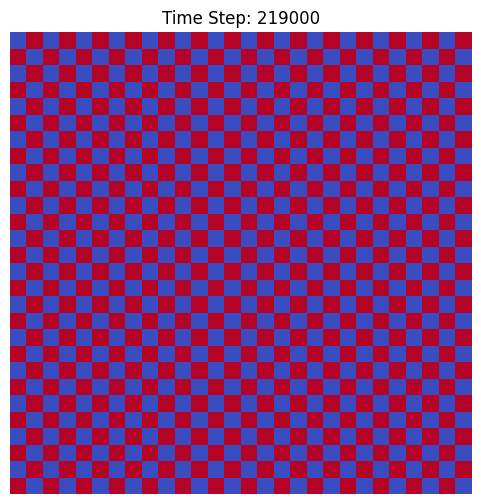

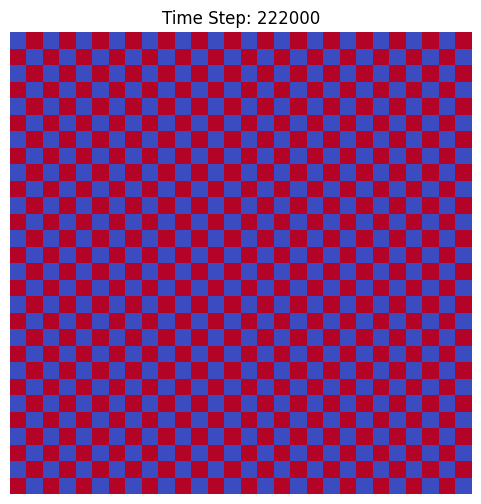

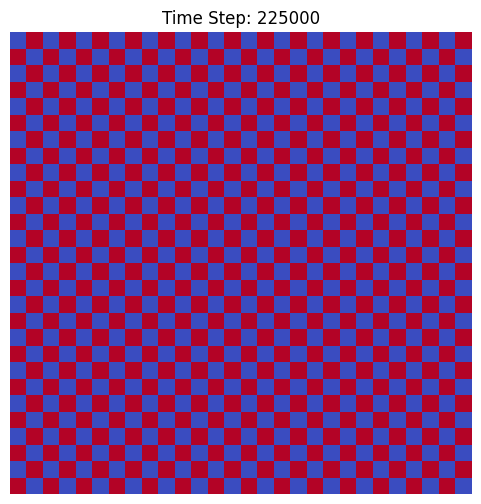

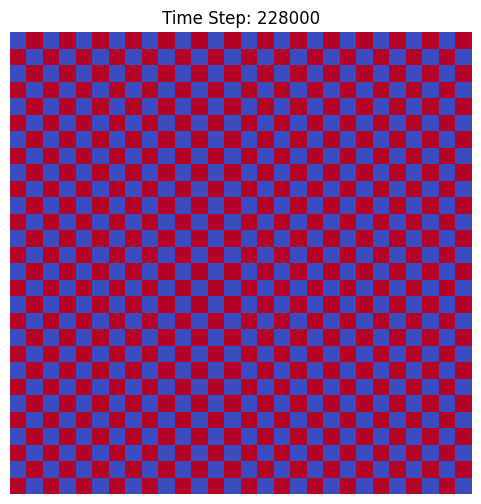

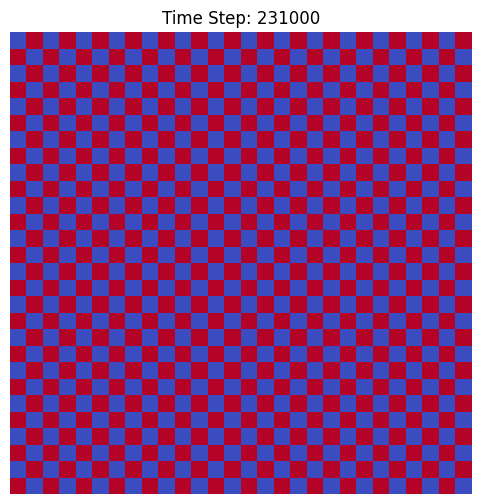

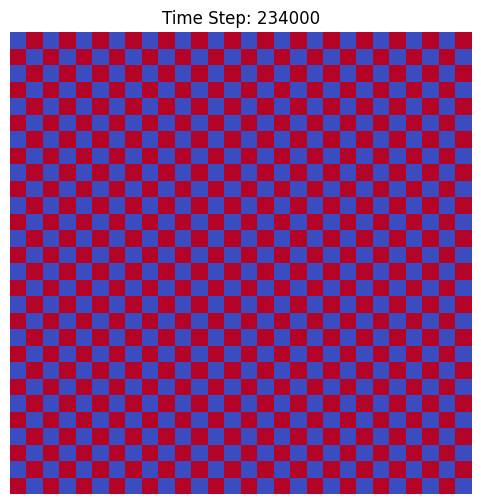

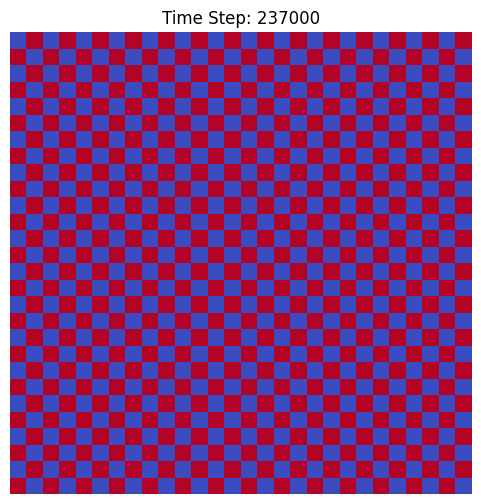

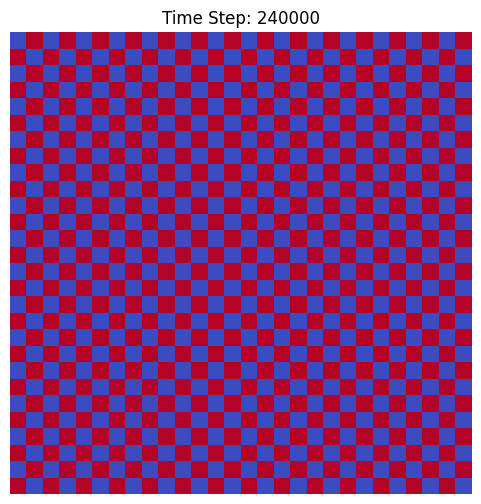

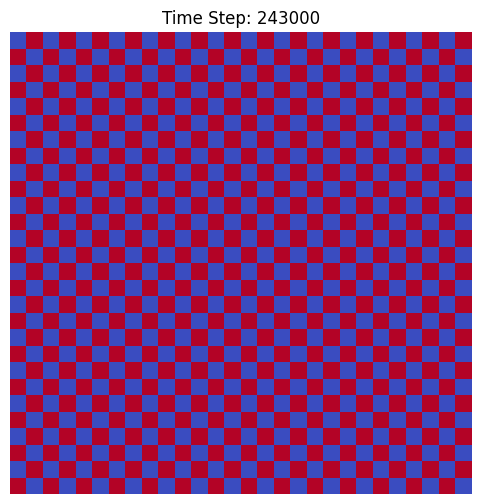

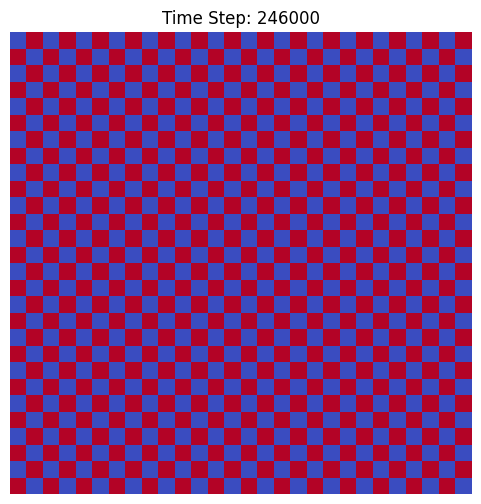

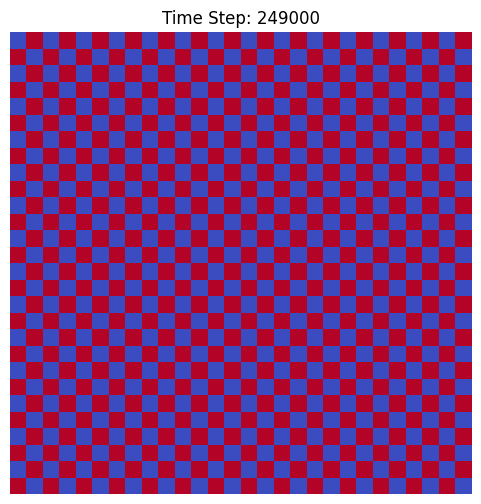

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from PIL import Image


# Parameters
epsilon = 0.02  # Gradient energy coefficient
dt = 0.01 * epsilon**2  # Reduced time step
T = 1         # Total simulation time
Nx, Ny = 28, 28  # Reduced grid size
Lx, Ly = 1.0, 1.0  # Domain size
dx, dy = Lx / Nx, Ly / Ny  # Grid spacing

# Initialize the phase field (random noise)
phi = np.random.uniform(-0.1, 0.1, (Nx, Ny))
# phi =jnp.tanh((2 -sqrt(xx*2 + yy*2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation


# Fourier space setup
kx = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
Kx, Ky = np.meshgrid(kx, ky, indexing='ij')
k_squared = Kx*2 + Ky*2

# Function to solve the Allen-Cahn equation in Fourier space
def allen_cahn_implicit(phi, dt, epsilon, k_squared):
    max_iter = 100  # Maximum number of iterations
    tol = 1e-6      # Convergence tolerance
    phi_new = phi.copy()
    
    for _ in range(max_iter):
        # Compute nonlinear term
        nonlinear_term = (phi_new - phi_new*3) / epsilon*2
        
        # Transform to Fourier space
        phi_hat = fft2(phi_new)
        nonlinear_hat = fft2(nonlinear_term)
        
        # Update in Fourier space
        phi_hat_new = (fft2(phi) + dt * nonlinear_hat) / (1 + dt * k_squared)
        
        # Transform back to real space
        phi_new_updated = np.real(ifft2(phi_hat_new))
        
        # Check for convergence
        if np.linalg.norm(phi_new_updated - phi_new) < tol:
            break
        
        phi_new = phi_new_updated
    
    return phi_new

# Simulation loop
time_steps = int(T / dt)
frames = []  # List to store frames for the animation

for step in range(time_steps):
    phi = allen_cahn_implicit(phi, dt, epsilon, k_squared)
    phi = np.clip(phi, -1.0, 1.0)  # Clip phi to prevent overflow
    
    # Print diagnostics
    # print(f"Time Step: {step}, Min: {np.min(phi)}, Max: {np.max(phi)}")
    if np.isnan(phi).any():
        print("NaN values detected in phi.")
        break
    
    # Plot at specific time steps
    if step % 3000 == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(phi, cmap='coolwarm', extent=[0, Lx, 0, Ly], origin='lower')
        # plt.colorbar(label='Phase Field')
        plt.title(f"Time Step: {step}")
        plt.xlabel("x")
        plt.ylabel("y")
        
        # Save the current frame as an image
        plt.axis('off')  # Turn off axes for cleaner animation
        plt.show()
        # plt.savefig(f"frames/frame_{step:04d}.png", bbox_inches='tight', pad_inches=0)
        # plt.close()
        
        # Append the image to the frames list
#         frames.append(Image.open(f"frames/frame_{step:04d}.png"))

# # Save the frames as a GIF using Pillow
# frames[0].save(
#     "allen_cahn_evolution_new.gif",
#     save_all=True,
#     append_images=frames[1:],
#     duration=200,  # Duration between frames in milliseconds
#     loop=0         # Loop indefinitely
# )

# print("Animation saved as 'allen_cahn_evolution.gif'")

In [2]:
import os
for step in range(0, time_steps, 30):

    os.remove(f"imp_frames/frame_{step:04d}.png")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'imp_frames/frame_30720.png'

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft, jfft2
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk):
         
        
            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))                                                                                 
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1)) 
    

        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  
        

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        v_hat = s_hat / denominator  
        uk = jfft.ifft2(v_hat)  
        uk = uk.reshape(self.N, self.N, 1)
     
        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        physical_loss = jnp.mean((u_ac - u_nn) ** 2)
        return physical_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def accuracy(self, data_test, pp2, qq2):
        uk_solver_list = []
        uk_nnetwork_list = []

        

        pp2 = jnp.expand_dims(pp2, axis=(0, -1)) 
        qq2 = jnp.expand_dims(qq2, axis=(0, -1))  
        

        for item in data_test:

            cahn = eps**2
            uk = jnp.real(item)
           

            # Compute denominator in Fourier space
            denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # Perform FFT calculations
            s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            v_hat = s_hat / denominator  
            uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork



    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.01 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 30000

data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9800:]




#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(dataset, data_test, nIter = epochs)
r2, mse, l2_rel, u_solver, u_pred = NN_model.accuracy(data_test, pp2, qq2)

NN_model.plot_losses(f'plots/training_log_iter_{epochs}.png')
